In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.stats import bootstrap
import astropy.units as u
from PIL import Image
from matplotlib.colors import LogNorm

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

ROOT = Path('../..').resolve()
results_dir = ROOT/'results/xSAGA-init'

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

#cosmology
c = FlatLambdaCDM(H0=70, Om0=0.3)


In [2]:
# sats after they've been crossmatched to hosts, in descending order of stellar mass
sats = pd.read_csv(results_dir/'sats_in_hosts.csv')

# SAGA-s2
saga_sats = pd.read_csv(ROOT/'data/saga_stage2_sats.csv')
saga_hosts = pd.read_csv(ROOT/'data/saga_stage2_hosts.csv', index_col='INTERNAL_HOSTID')

# More sanity checks on initial results (`sats_in_hosts` from nb 4)

## Surface brightness and color vs magnitude (Mao+2020 Fig 6)

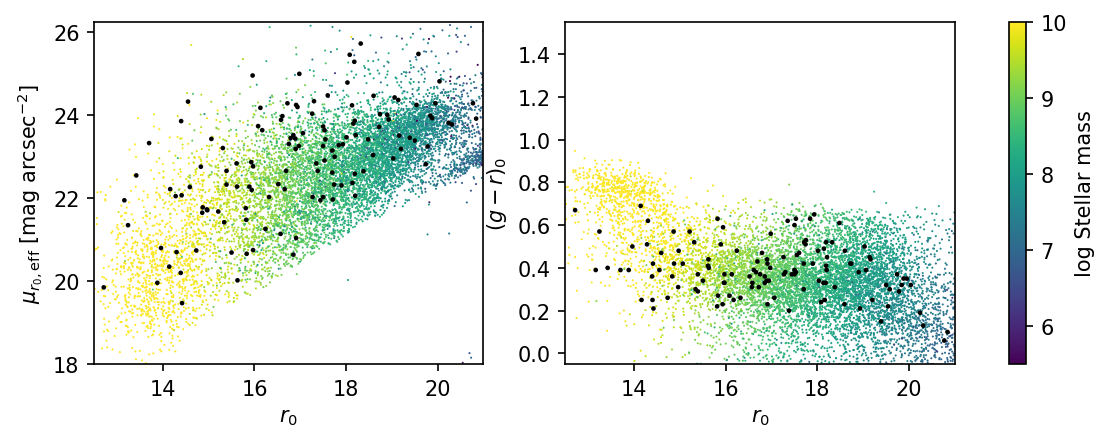

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.scatter(sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(12.5, 21)
ax1.set_ylim(18, 26.25)
ax1.set_xlabel(r'$r_0$')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

sc = ax2.scatter(sats.r0, sats.g0-sats.r0, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.R, saga_sats.GR, s=5, c='k', edgecolor='none')
ax2.set_xlim(12.5, 21)
ax2.set_ylim(-0.05, 1.55)
ax2.set_xlabel('$r_0$')
ax2.set_ylabel(r'$(g-r)_0$')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')



## Surface brightness vs physical radius and color (Mao+2020 Fig 9)

In [4]:
saga_sats['R_eff'] = np.sqrt(np.power(10, (saga_sats.MU_EFF - saga_sats.R) / 2.5) / (2*np.pi))
saga_sats['DIST'] = saga_hosts.loc[saga_sats.INTERNAL_HOSTID].DIST.values * 1000 # kpc
saga_sats['R_physical'] = (saga_sats.R_eff.values * u.arcsec).to(u.radian).value * saga_sats.DIST


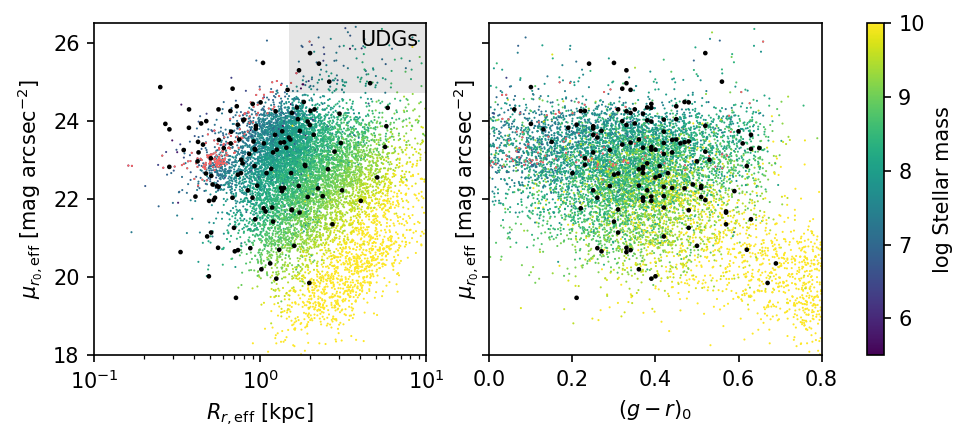

In [5]:
# Mao+2020 Fig 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True)

ax1.scatter(sats.R_physical, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(sats[sats.r0 > 20.75].R_physical, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.set_ylim(18, 26.5)
ax1.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax1.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax1.text(4, 25.9, 'UDGs', c='k')

sc = ax2.scatter(sats.g0-sats.r0, sats.mu_eff, c=sats.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(sats[sats.r0 > 20.75].g0-sats[sats.r0 > 20.75].r0, sats[sats.r0 > 20.75].mu_eff, c=c3, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.GR, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax2.set_xlim(0, 0.8)
ax2.set_ylim(18, 26.5)
ax2.set_xlabel(r'$(g-r)_0$')
ax2.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2])
cb.set_label('log Stellar mass')

Red points are those below SAGA completeness limit ($r_0 > 20.75$). Note that this plot includes more massive galaxies ($10^{10}$ $M_\odot$) that are larger, redder, and higher surface brightness than the others. These are probably quenched satellites in high-density environments.

# Satellites in relation to hosts

In [3]:
def load_NSA():
    """Returns dataframe with some NSA info.
    """
    nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

    # do this column by column, *not* on entire catalog
    byteorder = lambda x: x.byteswap().newbyteorder()

    # doesn't use .byteswap().newbyteorder() because that's super slow...
    return pd.DataFrame({
        'NSAID': byteorder(nsa.NSAID),
        'z_NSA': byteorder(nsa.Z),
        'ra_NSA': byteorder(nsa.RA),
        'dec_NSA': byteorder(nsa.DEC),
        'M_r_NSA': byteorder(nsa.ELPETRO_ABSMAG[:, 4]),
        'mass_NSA': byteorder(nsa.ELPETRO_MASS)
    })

In [4]:
# sats in hosts
sat_x_nsa = pd.read_csv(results_dir/'sat_x_NSA.csv')
sat_coords = SkyCoord(sat_x_nsa.ra, sat_x_nsa.dec, unit='deg')

# crossmatch hosts
nsa = load_NSA().set_index('NSAID')
nsa_coords = SkyCoord(nsa.ra_NSA, nsa.dec_NSA, unit='deg')

_, sep, _ = nsa_coords.match_to_catalog_sky(sat_coords)


In [5]:
hosts = nsa[sep < 1*u.deg].copy()
hosts = hosts[(hosts.mass_NSA < 1e14) & (hosts.mass_NSA > 1e8) & (hosts.z_NSA < 0.03) & (hosts.z_NSA > 0.005)].copy()

hosts.sort_values('mass_NSA', ascending=False, inplace=True)

len(hosts)

7891

Start with most massive hosts and work our way down, but now keep track of which host each satellite goes in. Save these host NSAIDs to the satellite dataframe. **Update -- getting rid of very nearby hosts, which will take up a huge swath of sky).**

In [6]:
host_dict = dict()

host_NSAID = -1 * np.ones(len(sat_x_nsa), dtype=int)
distances = -1 * np.ones(len(sat_x_nsa), dtype=float)

for host in tqdm(hosts.itertuples(), total=len(hosts)):
    nsaid, z, ra, dec, M_r, mass = host
    
    host_coords = SkyCoord(ra, dec, unit='deg')
    host_sep = host_coords.separation(sat_coords)
    
    kpc_per_deg = c.angular_diameter_distance(z).to(u.kpc).value * np.pi / 180 

    in_host = (host_sep.to(u.deg).value * kpc_per_deg < 300) # note: could change 300 kpc to something that scales with host mass 
    new_idxs = in_host & (host_NSAID == -1)    
    
    new_sats_in_host = sat_x_nsa[new_idxs]
    
    host_NSAID[new_idxs] = nsaid 
    distances[new_idxs] = host_sep[new_idxs] * kpc_per_deg
    
    n_sat_in_300kpc = len(new_sats_in_host)
    host_dict[nsaid] = [ra, dec, z, M_r, mass, n_sat_in_300kpc]


## Remake average number of satellites plot

In [7]:
host_df = pd.DataFrame.from_dict(
    host_dict, 
    orient='index', 
    columns=['ra', 'dec', 'z', 'M_r', 'mass', 'n_sat_in_300kpc'],
)
host_df.index.name = 'NSAID'
host_df.sample(5, random_state=42)

ra        dec         z        M_r          mass  \
NSAID                                                              
335570  237.971010  25.978340  0.022026 -19.598730  5.569860e+09   
444764  182.467186  38.730026  0.021305 -16.465109  5.007998e+08   
433370  166.442148  37.618204  0.025043 -19.150024  6.555668e+09   
293381  164.313011  46.753671  0.022692 -17.976593  2.121717e+09   
249850  224.599357  41.941446  0.028242 -17.582291  6.843204e+08   

        n_sat_in_300kpc  
NSAID                    
335570                2  
444764                0  
433370                0  
293381                1  
249850                0

**Correcting for self-matches**.

Attach these host properties to `sat_x_nsa`

In [8]:
sat_x_nsa['host_distance'] = distances
sat_x_nsa['host_NSAID'] = host_NSAID

sdf = sat_x_nsa.join(hosts, on='host_NSAID', how='left', rsuffix='_HOST')
sdf.sample(5)

objID          ra        dec        g0        r0  \
9054  1237662224062480532  170.257964  38.313695  18.03981  17.79563   
869   1237662498389753967  224.639206  43.876805  14.97552  14.57632   
4258  1237662301903061116  229.164876  42.953870  15.77656  15.34444   
3341  1237661212046524502  222.995780  43.728564  16.39155  16.42591   
1738  1237664817671766107  168.713524  35.502256  14.04914  13.14683   

          R_eff     p_sat      sep_NSA   NSAID     z_NSA      ra_NSA  \
9054   3.947146  0.916332  1590.797603  435537  0.006200  170.756700   
869    9.202677  0.977854     0.088166  632321  0.011945  224.639175   
4258  10.413820  0.976081     0.078469  341080  0.018000  229.164859   
3341  11.268080  0.965768   328.206157  632262  0.008352  222.944203   
1738   8.807241  0.973335     0.065105  658637  0.021473  168.713544   

        dec_NSA    M_r_NSA  host_distance  host_NSAID  z_NSA_HOST  \
9054  38.520017 -16.762610     203.256949      435537    0.006200   
869   43.876794 -18.287730       0.021550      632321    0.011945   
4258  42.953852 -18.923557       0.028692      341080    0.018000   
3341  43.645373 -18.109146      56.341417      632262    0.008352   
1738  35.502264 -20.917010       0.028280      658637    0.021473   

      ra_NSA_HOST  dec_NSA_HOST  M_r_NSA_HOST      mass_NSA  
9054   170.756700     38.520017    -16.762609  6.416527e+08  
869    224.639175     43.876794    -18.287729  1.223398e+09  
4258   229.164859     42.953852    -18.923557  2.348510e+09  
3341   222.944203     43.645373    -18.109146  7.434986e+08  
1738   168.713544     35.502264    -20.917009  3.051824e+10

In [9]:
# self-match NSAIDs
self_matches_NSAIDs = sdf.NSAID[sdf.NSAID == sdf.host_NSAID]

# subtract 1 from each of these
host_df['n_sat_in_300kpc'] = np.where(
    host_df.index.isin(self_matches_NSAIDs),
    host_df.n_sat_in_300kpc - 1,
    host_df.n_sat_in_300kpc
)

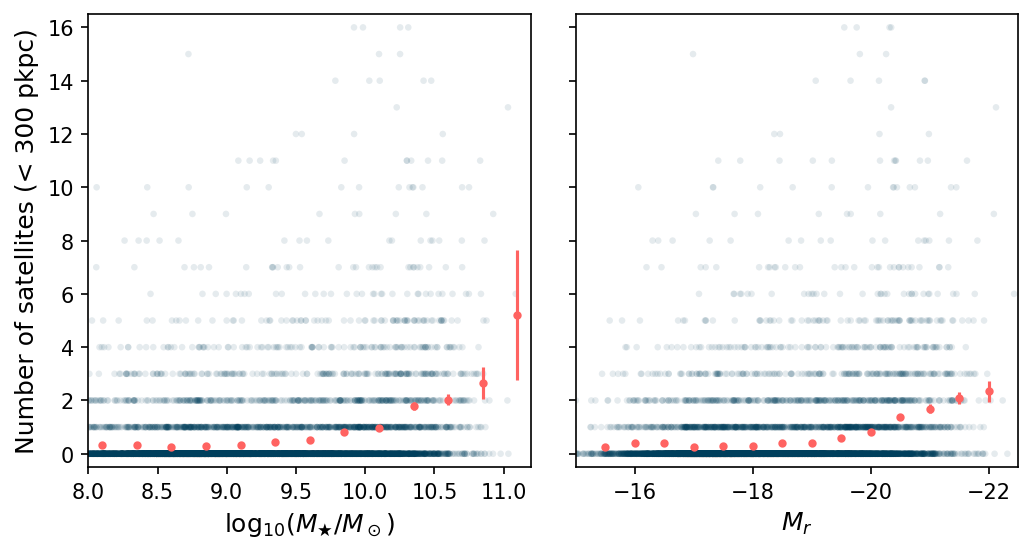

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

# plot stellar mass
ax1.scatter(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, edgecolors='none', s=10, alpha=0.1, c=c0)

mass_bins = np.arange(8., 11.5, 0.25)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    ) for m1, m2 in zip(mass_bins[:-1], mass_bins[1:])]
)

ax1.errorbar(mass_bins[:-1]+0.1, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax1.set_xlim(8.0, 11.2)
ax1.set_ylim(-0.5, 16.5)
ax1.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax1.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

# plot abs mag
ax2.scatter(host_df.M_r, host_df.n_sat_in_300kpc, edgecolors='none', s=10, alpha=0.1, c=c0)

mag_bins = np.arange(-22., -14.5, 0.5)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.M_r > mag1) & (host_df.M_r < mag2)].values,
        bootfunc=np.mean,
    ) for mag1, mag2 in zip(mag_bins[:-1], mag_bins[1:])]
)
ax2.errorbar(mag_bins[:-1], boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax2.set_xlim(-15, -22.5)
ax2.set_xlabel(r'$M_{r}$', fontsize=12)

fig.subplots_adjust(wspace=0.1)



Plot again but with a 2d histogram below the mean trend.

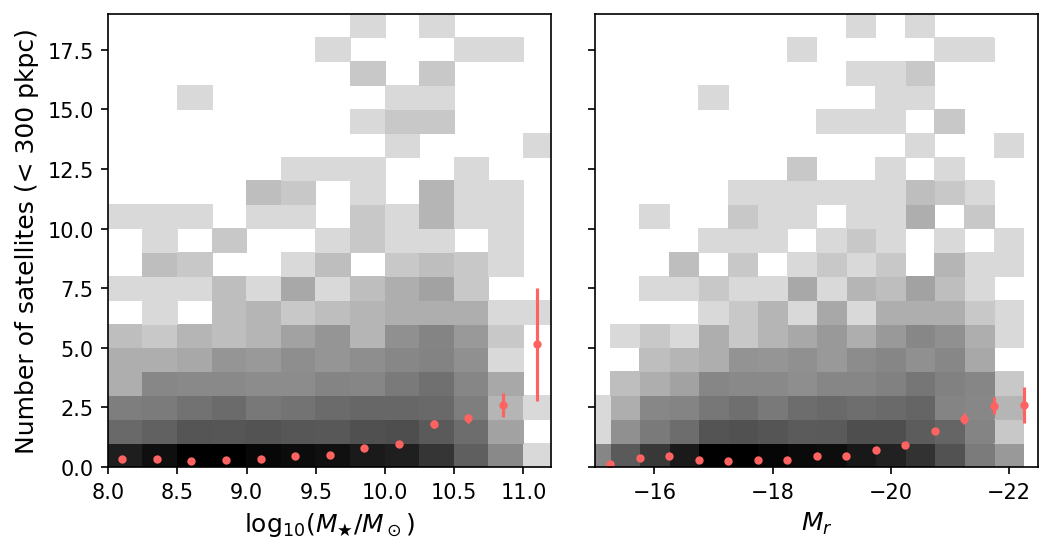

In [87]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

# plot stellar mass
mass_bins = np.arange(8., 11.5, 0.25)
ax1.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e3))

boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    ) for m1, m2 in zip(mass_bins[:-1], mass_bins[1:])]
)

ax1.errorbar(mass_bins[:-1]+0.1, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax1.set_xlim(8.0, 11.2)
ax1.set_ylim(-0.5, 20.5)
ax1.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax1.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

# plot abs mag
ax2.hist2d(host_df.M_r, host_df.n_sat_in_300kpc, edgecolors='none', bins=(mag_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e3))

mag_bins = np.arange(-22.25, -14.5, 0.5)
boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.M_r > mag1) & (host_df.M_r < mag2)].values,
        bootfunc=np.mean,
    ) for mag1, mag2 in zip(mag_bins[:-1], mag_bins[1:])]
)
ax2.errorbar(mag_bins[:-1], boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax2.set_xlim(-15, -22.5)
ax2.set_xlabel(r'$M_{r}$', fontsize=12)

fig.subplots_adjust(wspace=0.1)



1192
2251
1789
1404
1033
216


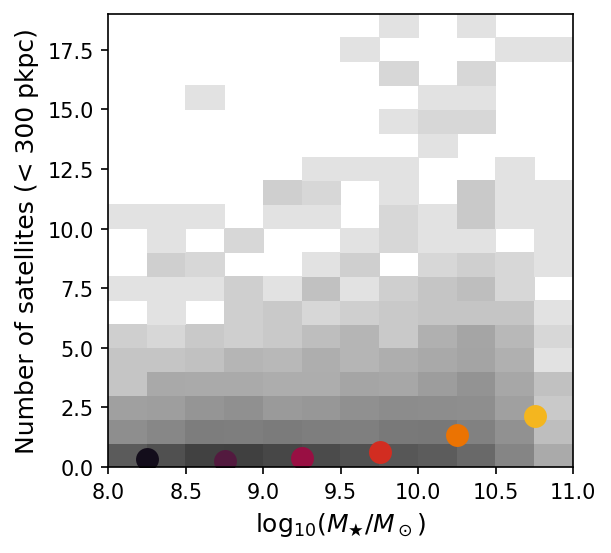

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# plot stellar mass
mass_bins = np.arange(8., 11.25, 0.25)
ax.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e4))

for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):
    
    boot_n_sat = bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    )
    
    print(sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)))
    
    ax.errorbar((m1+m2)/2, boot_n_sat.mean(), yerr=boot_n_sat.std(), color=color, marker='o', markersize=10)
    
ax.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

## Radial distribution of satellites

Again, remove self-matches (now from `sdf`)

In [10]:
sdf = sdf[sdf.NSAID != sdf.host_NSAID].copy()
sdf.sample(5)

objID          ra        dec        g0        r0  \
7857  1237664877801832715  141.272673  28.049225  20.39737  20.37024   
415   1237662303514394981  232.112977  43.006352  19.24695  18.79399   
349   1237664852042449154  236.344223  24.506206  16.40123  16.27151   
1999  1237664835926360508  127.252929  21.963366  17.36046  16.92756   
3804  1237664852566605905  204.992926  35.285847  18.26999  18.02109   

         R_eff     p_sat      sep_NSA   NSAID     z_NSA      ra_NSA  \
7857  3.013947  0.935469  1042.594439  409824  0.021709  141.095343   
415   3.352293  0.974782   154.927447  632674  0.028600  232.167159   
349   8.814544  0.941808     9.275616  466675  0.022975  236.346987   
1999  5.905850  0.955452     0.182795  407253  0.020406  127.252981   
3804  2.465274  0.962468   970.435242  432747  0.025059  204.917866   

        dec_NSA    M_r_NSA  host_distance  host_NSAID  z_NSA_HOST  \
7857  28.293021 -20.521263      -1.000000          -1         NaN   
415   43.023163 -16.169550     119.503040      210788    0.018557   
349   24.506766 -19.868286     208.135145      632836    0.022669   
1999  21.963383 -17.459711     157.695895      406778    0.020354   
3804  35.023361 -19.551462      -1.000000          -1         NaN   

      ra_NSA_HOST  dec_NSA_HOST  M_r_NSA_HOST      mass_NSA  
7857          NaN           NaN           NaN           NaN  
415    232.053128     42.929883    -20.683899  2.663283e+10  
349    236.319932     24.630522    -21.176409  4.351649e+10  
1999   127.192146     22.053440    -20.750170  2.908295e+10  
3804          NaN           NaN           NaN           NaN

In [ ]:
# sdf.to_csv(results_dir/'sdf-nb05.csv')

Originally we had this, but it was incorrectly normalized

```python
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=2)
    
    ax.text(5, 1.75+i/4, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)
```

248 1192
359 2251
457 1789
663 1404
1029 1033
373 216


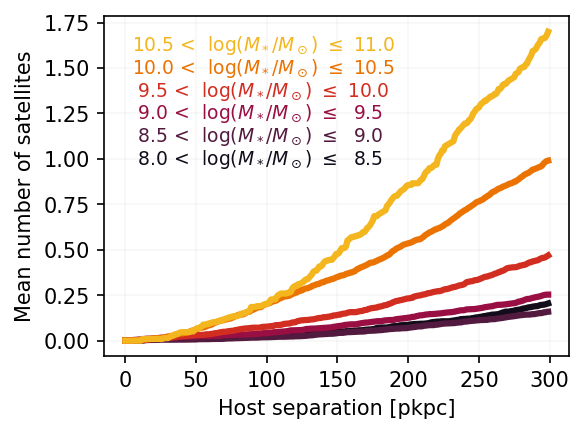

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(5, 1+i/8, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

1029 1033
373 216


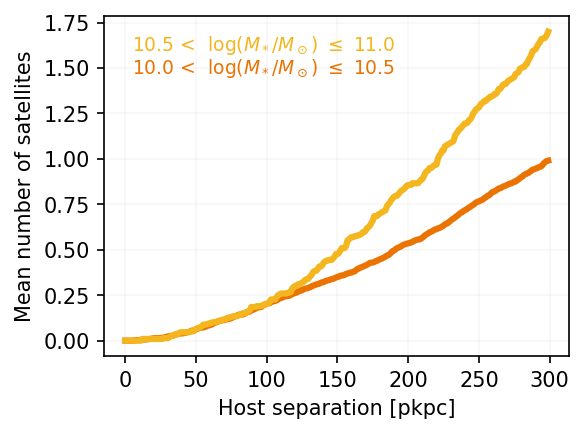

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(10, 11, 0.5), np.arange(10.5, 11.5, 0.5), cmr.ember([0.74, 0.9]))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(5, 1.5+i/8, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

248 1192
359 2251
457 1789
663 1404
1029 1033
373 216


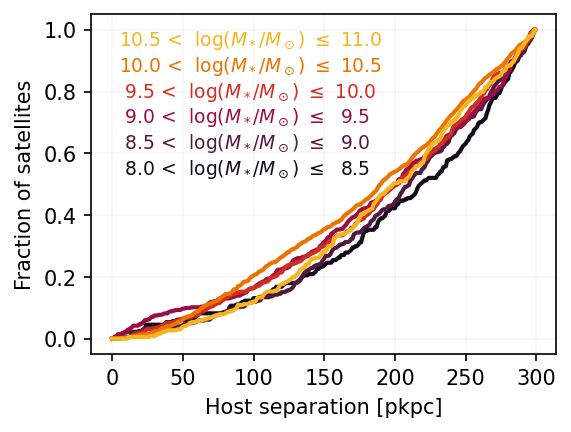

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat.max(), color=color, lw=2)
    
    ax.text(5, 0.55+i/12, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

248 1192
359 2251
457 1789
663 1404
1029 1033
373 216


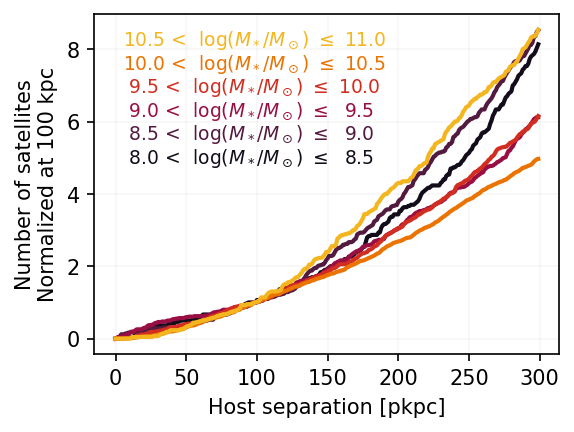

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(8, 11, 0.5), np.arange(8.5, 11.5, 0.5), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))  # number of hosts (only those that have a satellite around them)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat[99], color=color, lw=2)
    
    ax.text(5, 5+0.65*i, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Number of satellites\nNormalized at 100 kpc')

ax.grid(alpha=0.1)

### Another way of slicing up mass bins

752
652
601
432
175
41


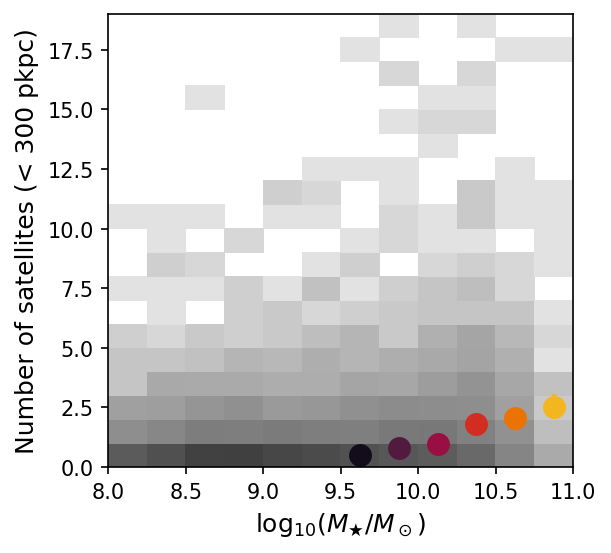

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# plot stellar mass
mass_bins = np.arange(8., 11.25, 0.25)
ax.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 1e4))

for i, (m1, m2, color) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)))):
    
    boot_n_sat = bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    )
    
    print(sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)))
    
    ax.errorbar((m1+m2)/2, boot_n_sat.mean(), yerr=boot_n_sat.std(), color=color, marker='o', markersize=10, lw=2)
    
ax.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

290 752
373 652
416 601
613 432
279 175
94 41


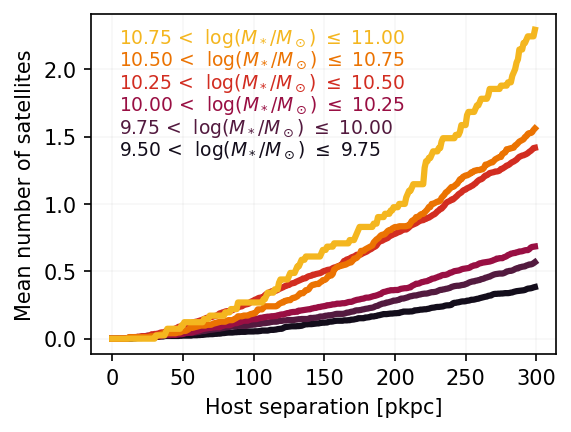

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(5, 1.4+i/6, f'{m1:>4.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

290 752
373 652
416 601
613 432
279 175
94 41


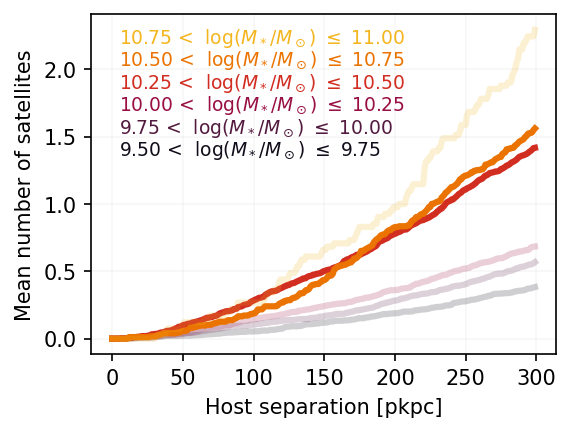

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color, alpha) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)), [0.2, 0.2, 0.2, 1, 1, 0.2])):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat, color=color, lw=3, alpha=alpha)
    
    ax.text(5, 1.4+i/6, f'{m1:>4.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

290 752
373 652
416 601
613 432
279 175
94 41


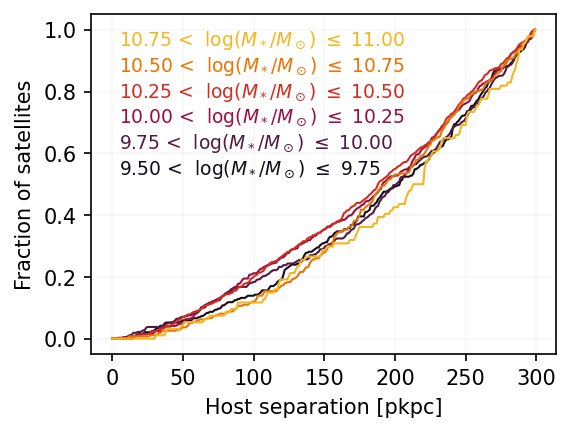

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

radius_range = np.arange(0, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)))):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(sdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
    
    ax.plot(radius_range, cdf_sat / cdf_sat.max(), color=color, lw=1)
    
    ax.text(5, 0.55+i/12, f'{m1:>4.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

### Bootstrap resample (with std errors) on separate subplots

290 752
373 652
416 601
613 432
279 175
94 41


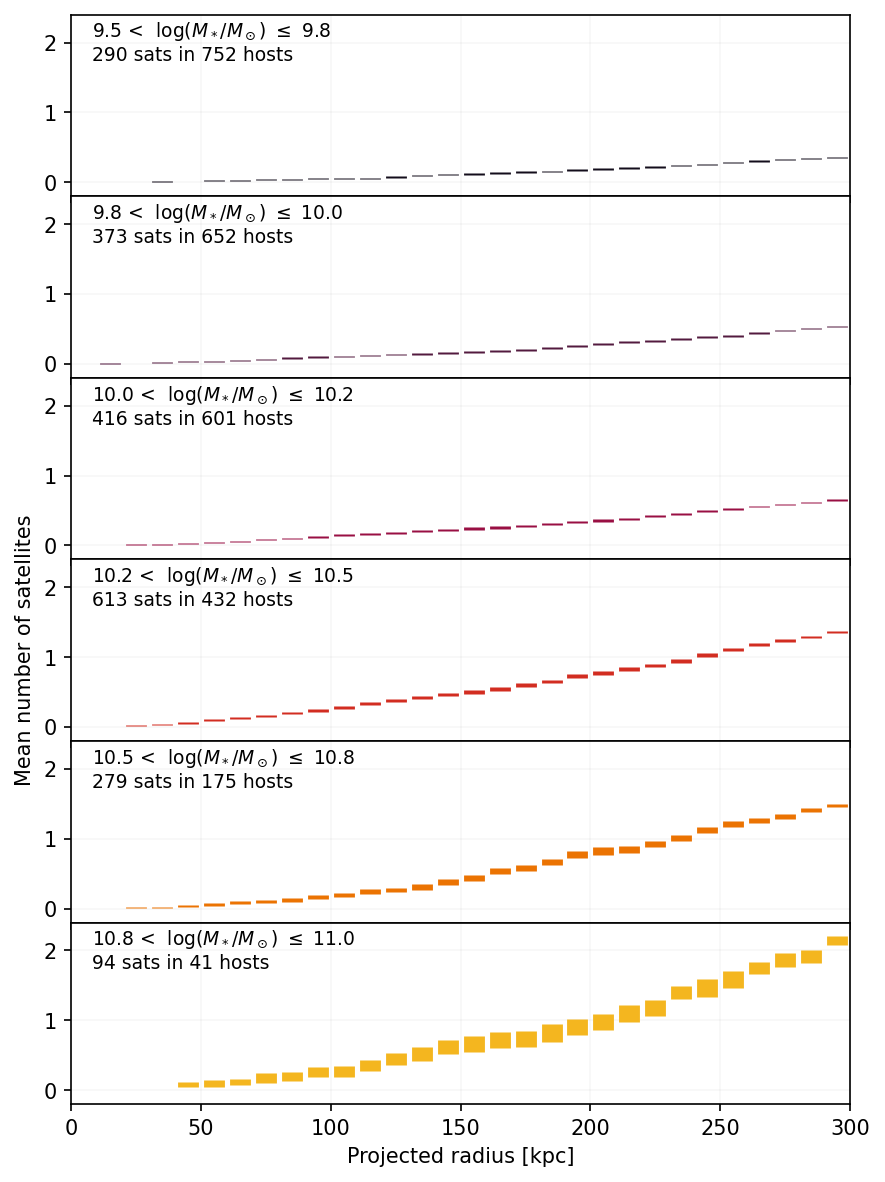

In [169]:
fig, axes = plt.subplots(6, 1, figsize=(6, 8), dpi=150, sharex=True)

radius_range = np.arange(0, 300, 10)

# loop through mass bins
for i, (m1, m2, color, ax) in enumerate(zip(np.arange(9.5, 11, 0.25), np.arange(9.75, 11.25, 0.25), cmr.ember(np.linspace(0.1, 0.9, 6)), axes.flat)):

    in_mass_range = (sdf.mass_NSA > 10**m1) & (sdf.mass_NSA <= 10**m2) & (sdf.host_distance > 0)

    N_sats = sum(in_mass_range)
#     N_hosts = len(np.unique(sdf[in_mass_range & (sdf.host_NSAID != -1)].host_NSAID))
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)


    print(N_sats, N_hosts)
    
    boot_cdf_sat = np.array([
        bootstrap(
            sdf[in_mass_range].host_distance.values,
            bootfunc=lambda x: sum((x < r)) / N_hosts
        ) for r in radius_range
    ])
    
    ax.errorbar(radius_range+5, boot_cdf_sat.mean(1), boot_cdf_sat.std(1), c=color, lw=10, ls='')
    ax.set_xlim(0, 300)
    ax.set_ylim(-0.2, 2.4)
    ax.grid(alpha=0.1)
    
    
    ax.text(8, 2.0, f'{m1:.1f} <  log($M_*/M_\odot$) $\leq$ {m2:.1f}' '\n' f'{N_sats} sats in {N_hosts} hosts', va='center',fontsize=9)
    
axes.flat[-1].set_xlabel('Projected radius [kpc]')
axes.flat[3].set_ylabel('Mean number of satellites')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

### Look at two host bins

613
279


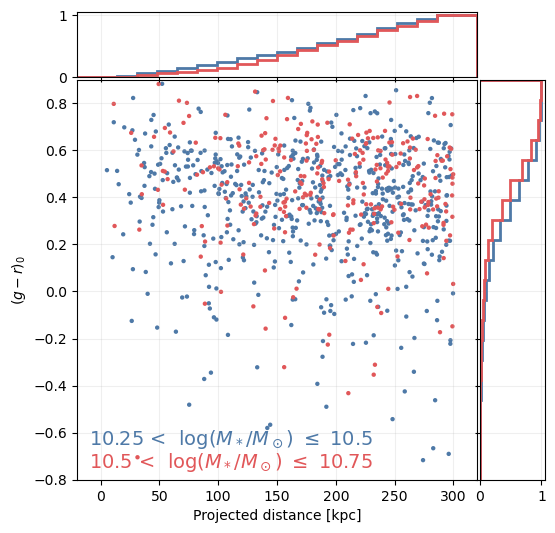

In [168]:
# organize data
sdf_a = sdf[(sdf.mass_NSA > 10**10.25) & (sdf.mass_NSA <= 10**10.5)]
sdf_b = sdf[(sdf.mass_NSA > 10**10.5) & (sdf.mass_NSA <= 10**10.75)]
sdf_c = sdf[(sdf.mass_NSA > 10**10.75) & (sdf.mass_NSA <= 10**11)]


# organize subplots
left, width = 0.07, 0.8
bottom, height = 0.07, 0.8
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.13]
rect_histy = [left + width + spacing, bottom, 0.13, height]

fig = plt.figure(figsize=(5, 5), dpi=100)

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# plot

ax.set_xlim(-20, 320)
ax.set_ylim(-0.8, 0.9)

for df_, color in zip([sdf_a, sdf_b], ['#4e79a7', '#e15759']):
    ax.scatter(df_.host_distance, df_.g0-df_.r0, color=color, s=10, edgecolor='none')
    ax_histx.hist(df_.host_distance, density=True, cumulative=True, bins=20, range=ax.get_xlim(), color=color, histtype='step', lw=2)
    ax_histy.hist(df_.g0-df_.r0, density=True, cumulative=True, bins=20, range=ax.get_ylim(), color=color, orientation='horizontal', histtype='step', lw=2)
    print(len(df_))

ax.grid(alpha=0.2)
ax_histx.grid(alpha=0.2)
ax_histy.grid(alpha=0.2)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.text(-10, -0.65, '10.25 <  log($M_*/M_\odot$) $\leq$ 10.5', color='#4e79a7', fontsize=14)
ax.text(-10, -0.75, '10.5 <  log($M_*/M_\odot$) $\leq$ 10.75', color='#e15759', fontsize=14)

ax.set_xlabel('Projected distance [kpc]')
ax.set_ylabel(r'$(g-r)_0$')

plt.show()

### Investigating galaxies within 50-150 kpc and in the most massive hosts

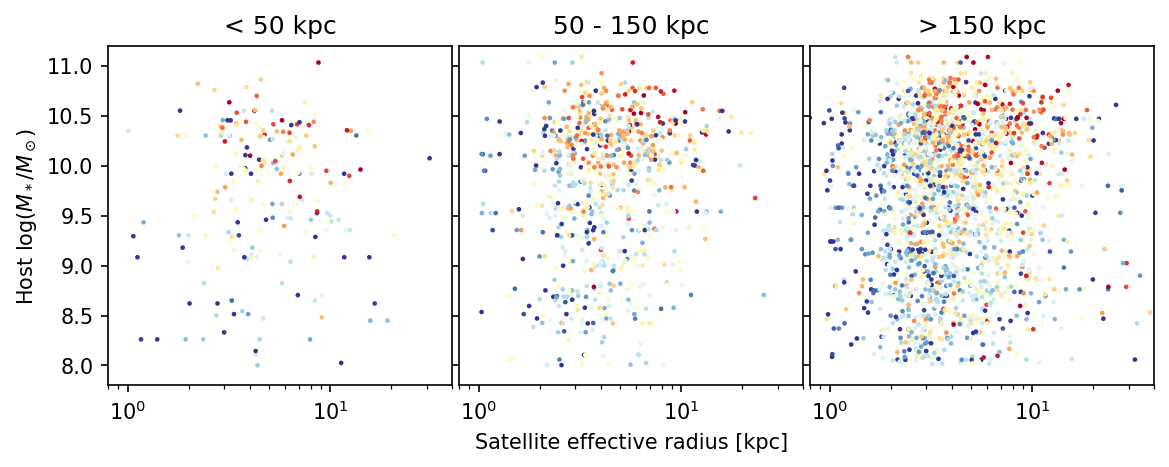

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150, sharey=True)

for ax, crit, title in zip(
    axes.flat, 
    [(sdf.host_distance < 50), (sdf.host_distance > 50) & (sdf.host_distance < 150), (sdf.host_distance > 150)],
    ['< 50 kpc', '50 - 150 kpc', '> 150 kpc']
):
    sdf_vir = sdf[crit]
    
    ax.scatter(sdf_vir.R_eff, np.log10(sdf_vir.mass_NSA), s=5, edgecolor='none', c=sdf_vir.g0-sdf_vir.r0, vmin=0, vmax=0.8, cmap='RdYlBu_r')
    ax.set_xscale('log')
    ax.set_xlim(0.8, 40)
    ax.set_ylim(7.8, 11.2)
    ax.set_title(title);

axes.flat[1].set_xlabel('Satellite effective radius [kpc]')
axes.flat[0].set_ylabel('Host log($M_*/M_\odot$)')
fig.subplots_adjust(wspace=0.02)

## Other quantities in relation to distance from host

In [21]:
sdf['mu_eff'] = sdf.r0 + 5*np.log10(sdf.R_eff) + 2.5*np.log10(2*np.pi)

# assuming that it is at the redshift of the host
sdf['DIST'] = c.luminosity_distance(sdf.z_NSA_HOST).to(u.Mpc).value
sdf['M_r'] = sdf.r0 - 5*np.log10(sdf.DIST*1e6) + 5
sdf['logmass_sat'] = 1.254 + 1.098*(sdf.g0-sdf.r0) - 0.4*sdf.M_r

sdf['R_physical'] = (sdf.R_eff.values * u.arcsec).to(u.radian).value * sdf.DIST*1e3


/home/john/anaconda3/envs/xSAGA/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Save `sdf` in this notebook... (and get rid of old one)

In [30]:
sdf.to_csv(results_dir/'sats_in_hosts_nb5.csv', index=False)
sdf = pd.read_csv(results_dir/'sats_in_hosts_nb5.csv')

### Colored by $g-r$ color

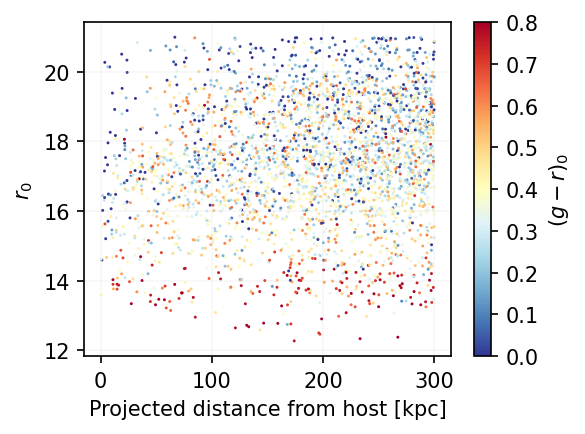

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].r0, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'$r_0$')

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

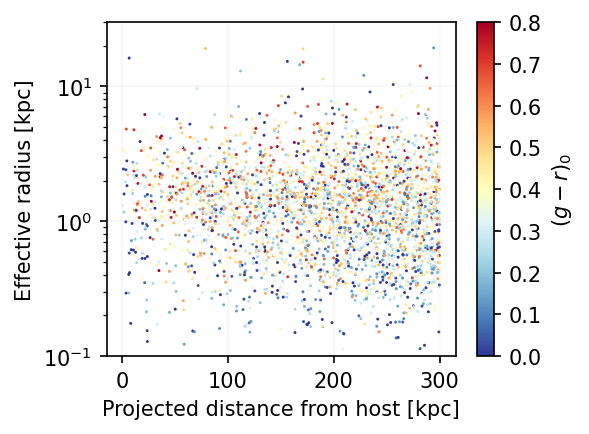

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'Effective radius [kpc]')

ax.grid(alpha=0.1)
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

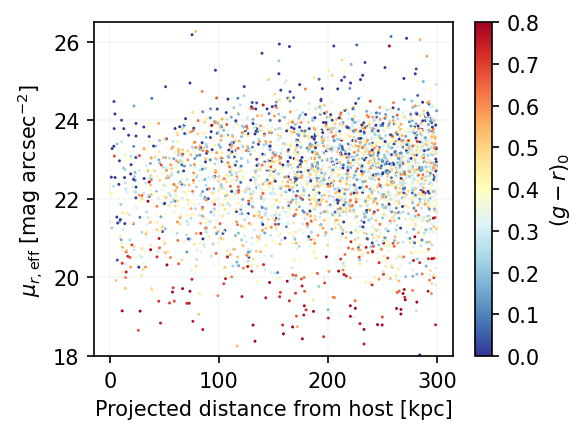

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].host_distance.values, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=(sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=0.8, 
    cmap='RdYlBu_r'
)

ax.set_xlabel('Projected distance from host [kpc]')
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')

ax.grid(alpha=0.1)
ax.set_ylim(18, 26.5)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

fig.tight_layout()

### Colored by distance from host

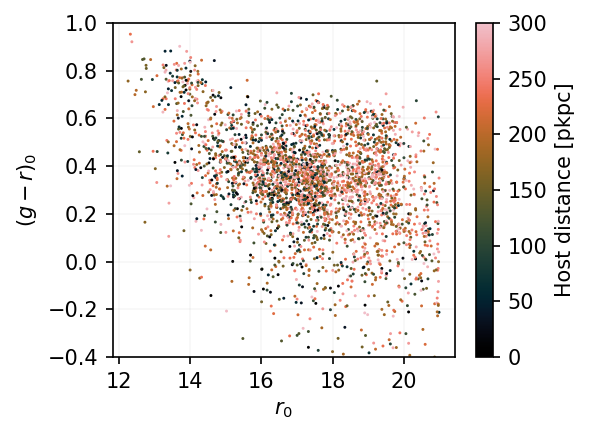

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    (sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'$(g-r)_0$')
ax.set_ylim(-0.4, 1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

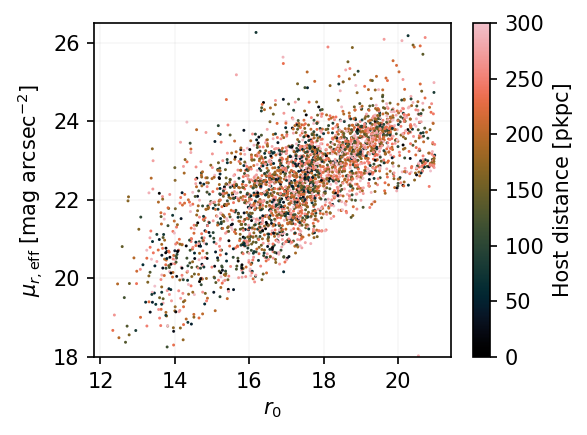

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')
ax.set_ylim(18, 26.5)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

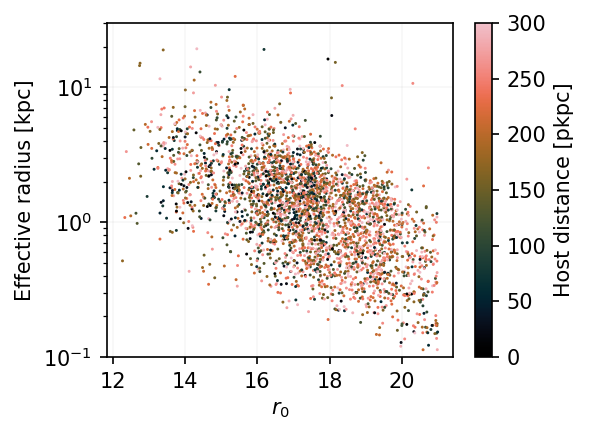

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].r0, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$r_0$')
ax.set_ylabel(r'Effective radius [kpc]')
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

Based on these results, I'm not seeing any strong biases as a function of host distance or $r_0$

### Same as above but with absolute mag

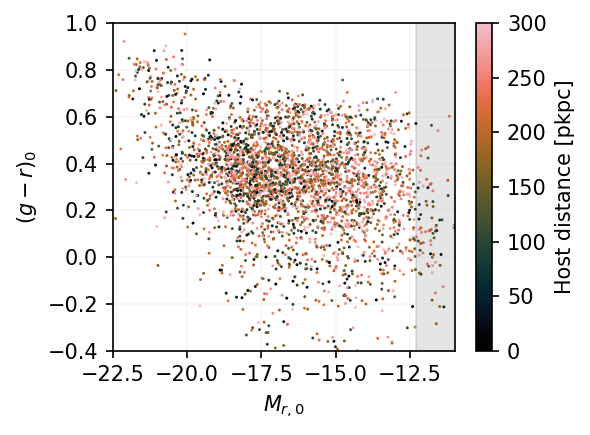

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    (sdf.g0-sdf.r0)[sdf.host_NSAID != -1], 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_ylabel(r'$(g-r)_0$')
ax.set_xlim(-22.5, -11)
ax.set_ylim(-0.4, 1)

ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

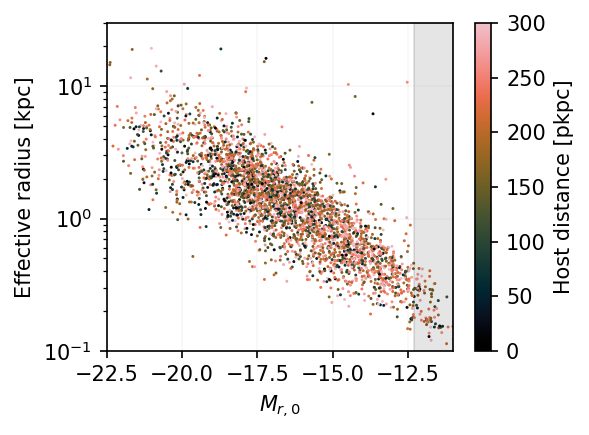

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    sdf[sdf.host_NSAID != -1].R_physical, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_xlim(-22.5, -11)

ax.set_ylabel(r'Effective radius [kpc]')
ax.set_ylim(0.1, 30)
ax.set_yscale('log')

ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

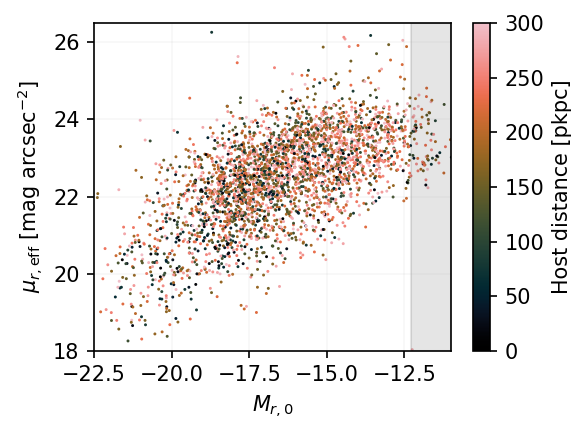

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sc = ax.scatter(
    sdf[sdf.host_NSAID != -1].M_r, 
    sdf[sdf.host_NSAID != -1].mu_eff, 
    c=sdf[sdf.host_NSAID != -1].host_distance.values, 
    s=2, 
    edgecolor='none', 
    vmin=0, 
    vmax=300, 
    cmap='cmr.dusk'
)

ax.set_xlabel('$M_{r,0}$')
ax.set_xlim(-22.5, -11)
ax.set_ylabel(r'$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]')
ax.set_ylim(18, 26.5)
ax.axvspan(-12.3, -11, color='k', alpha=0.1)

ax.grid(alpha=0.1)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Host distance [pkpc]')

fig.tight_layout()

## Remake Mao+2020 plots

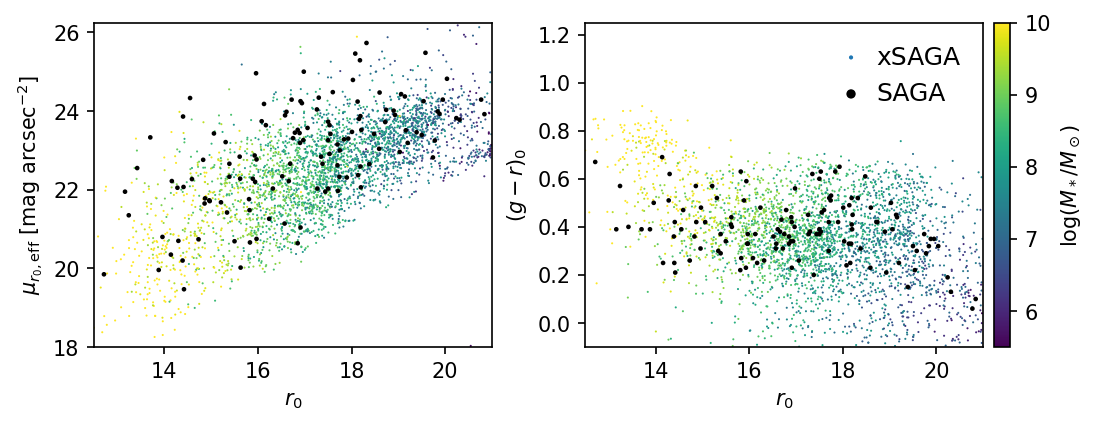

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

ax1.scatter(sdf.r0, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(12.5, 21)
ax1.set_ylim(18, 26.25)
ax1.set_xlabel(r'$r_0$')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

sc = ax2.scatter(sdf.r0, sdf.g0-sdf.r0, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10, label='xSAGA')
ax2.scatter(saga_sats.R, saga_sats.GR, s=5, c='k', edgecolor='none', label='SAGA')
ax2.set_xlim(12.5, 21)
ax2.set_ylim(-0.1, 1.25)
ax2.set_xlabel('$r_0$')
ax2.set_ylabel(r'$(g-r)_0$')

ax2.legend(fontsize=12, markerscale=2, framealpha=0, handletextpad=0.02)

fig.tight_layout(pad=1.5)

cb = fig.colorbar(sc, ax=[ax1, ax2], pad=0.01)
cb.set_label(r'log($M_*/M_\odot$)')


It seems that our CNN finds candidates that are very blue: $(g-r)_0 < 0.2$.

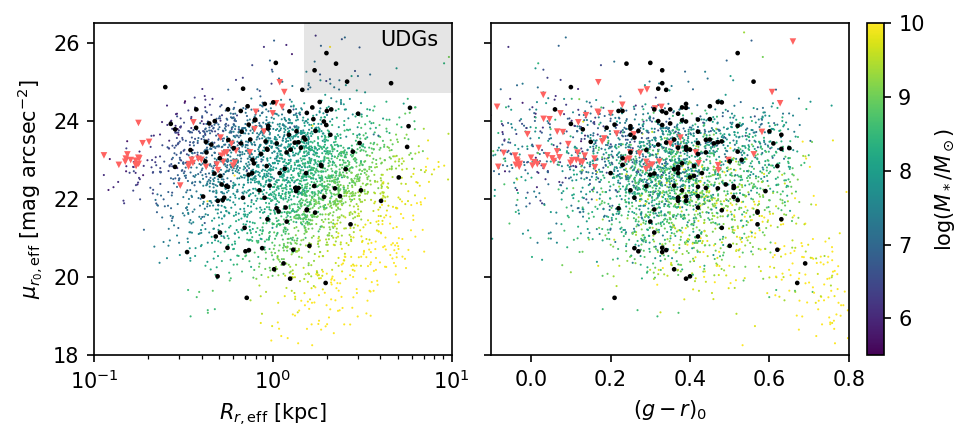

In [40]:
# Mao+2020 Fig 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True)

ax1.scatter(sdf.R_physical, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax1.scatter(sdf[sdf.r0 > 20.75].R_physical, sdf[sdf.r0 > 20.75].mu_eff, c=c3, s=10, edgecolor='none', marker='v', vmin=5.5, vmax=10)
ax1.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax1.set_xlim(0.1, 10)
ax1.set_xscale('log')
ax1.set_ylim(18, 26.5)
ax1.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax1.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax1.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax1.text(4, 25.9, 'UDGs', c='k')

sc = ax2.scatter(sdf.g0-sdf.r0, sdf.mu_eff, c=sdf.logmass_sat, s=1, edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(sdf[sdf.r0 > 20.75].g0-sdf[sdf.r0 > 20.75].r0, sdf[sdf.r0 > 20.75].mu_eff, c=c3, s=10, marker='v', edgecolor='none', vmin=5.5, vmax=10)
ax2.scatter(saga_sats.GR, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax2.set_xlim(-0.1, 0.8)
ax2.set_ylim(18, 26.5)
ax2.set_xlabel(r'$(g-r)_0$')

fig.tight_layout()

cb = fig.colorbar(sc, ax=[ax1, ax2], pad=0.02)
cb.set_label(r'log($M_*/M_\odot$)')

There are also quite a few large galaxies with high surface brightnesses. My intuition is that these are just red galaxies in group or cluster environments.

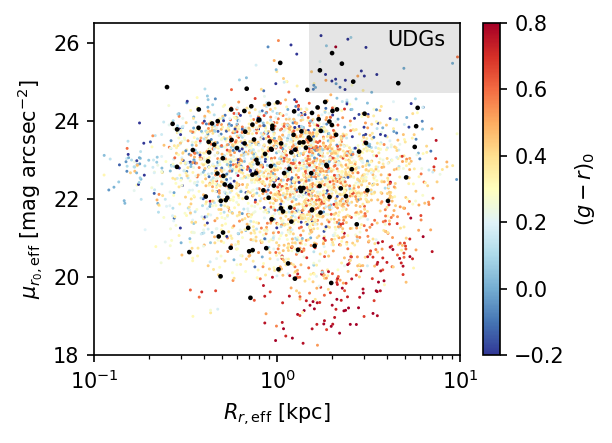

In [41]:
# Mao+2020 Fig 9
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150, sharey=True)

sc = ax.scatter(sdf.R_physical, sdf.mu_eff, c=sdf.g0-sdf.r0, s=2, edgecolor='none', vmin=-0.2, vmax=0.8, cmap='RdYlBu_r')
ax.scatter(saga_sats.R_physical, saga_sats.MU_EFF, s=5, c='k', edgecolor='none')
ax.set_xlim(0.1, 10)
ax.set_xscale('log')
ax.set_ylim(18, 26.5)
ax.set_xlabel(r'$R_{r,\rm eff}$ [kpc]')
ax.set_ylabel(r'$\mu_{r_0,\rm eff}$ [mag arcsec$^{-2}$]')

# UDGs mu_eff > 24.7, R_eff > 1.5 kpc
ax.fill_between(x=[1.5, 30], y1=24.7, y2=27, color='k', alpha=0.1, lw=0,)
ax.text(4, 25.9, 'UDGs', c='k')


fig.tight_layout()

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'$(g-r)_0$')

# Isolated low-$z$ galaxies?

In [41]:
sats = pd.read_csv(results_dir/'all_sats.csv')
sats

objID          ra        dec        g0        r0  \
0     1237658611977683171  158.800296  46.236739  16.74269  16.63662   
1     1237658205594255594  215.662531  46.523653  17.09699  16.75046   
2     1237662661594513672  210.489465  36.168611  17.54862  17.17523   
3     1237664853642641571  211.454811  34.821669  16.66302  16.30888   
4     1237664869753815354  151.808694  30.781045  20.51001  20.04107   
...                   ...         ...        ...       ...       ...   
9226  1237657776619585730  141.516264  44.733895  17.66065  17.44162   
9227  1237659162809401767  236.425513  44.511237  18.03398  17.63797   
9228  1237661357540115170  170.692705  46.598638  19.04106  18.70818   
9229  1237657771243405446  139.907581  48.266706  15.79002  15.28462   
9230  1237655109438275971  134.248132  48.750449  20.12919  19.99568   

         R_eff     p_sat      sep_NSA   NSAID     z_NSA      ra_NSA  \
0     4.760215  0.973726     0.156747  182632  0.001683  158.800279   
1     6.126145  0.956580     0.961786  249487  0.015607  215.662146   
2     3.863583  0.975288     3.308254  331199  0.017141  210.490307   
3     6.990974  0.975213     0.274055  393744  0.025648  211.454899   
4     2.715549  0.761499   682.554548  414418  0.021374  151.594510   
...        ...       ...          ...     ...       ...         ...   
9226  3.946793  0.976916     0.376029  146037  0.010464  141.516375   
9227  5.081613  0.966708     1.018683  262310  0.019347  236.425909   
9228  3.597445  0.954951   458.006085  295154  0.017476  170.583304   
9229  6.289228  0.740016  1401.178661  164727  0.027257  140.461214   
9230  2.538466  0.972845    88.823887  648005  0.017291  134.248820   

        dec_NSA    M_r_NSA  host_nsaid     host_sep  
0     46.236697 -13.112530      182641  1171.313063  
1     46.523622 -16.801690      249449  3020.330724  
2     36.169229 -16.834050      331220  1189.169586  
3     34.821645 -18.302956      393741   439.913105  
4     30.826910 -18.264923      414332  1056.711582  
...         ...        ...         ...          ...  
9226  44.733827 -15.296142      155996  1261.393875  
9227  44.511251 -16.329615      210968  4230.543805  
9228  46.701333 -18.293596      295159  1393.691726  
9229  48.142835 -19.439669      164727  1401.178661  
9230  48.775118 -17.292812       78001  1925.017878  

[9231 rows x 15 columns]

In [58]:
iso_df = sats[sats.sep_NSA > 1*3600].copy()
iso_df.shape

(22, 15)

In [57]:
iso_df[['ra', 'dec']]

ra        dec
32    230.348583  28.560922
150   236.382029  32.167711
556   192.788261  38.552445
706   228.342119  31.376709
854   226.196968  29.718567
948   213.103396  44.460869
2288  228.320312  30.585249
2438  238.398177  32.305701
2612  237.446733  30.796157
2668  227.642968  31.605168
3225  226.705112  32.918394
3287  230.263520  28.518553
3324  230.945961  27.798749
3330  226.416881  31.577160
4586  228.095523  30.815147
5299  226.311532  32.603333
5889  230.263844  28.518800
6678  151.532542  49.568232
6802  239.942154  37.038939
6850  225.678317  31.568446
8112  226.642992  31.734726
8537  237.206454  37.428923

# Look at xSAGA candidates very close to hosts

In [67]:
sdf = pd.read_csv(results_dir/'sdf-nb05.csv', index_col=0)

In [74]:
sdf

objID          ra        dec        g0        r0  \
0     1237658611977683171  158.800296  46.236739  16.74269  16.63662   
2     1237662661594513672  210.489465  36.168611  17.54862  17.17523   
3     1237664853642641571  211.454811  34.821669  16.66302  16.30888   
7     1237661383844037025  140.183088  33.654677  18.06971  17.55748   
8     1237661384386216002  153.688895  38.981000  14.46129  13.63036   
...                   ...         ...        ...       ...       ...   
9223  1237662224600793169  174.322087  39.285195  16.75909  16.65799   
9224  1237661356468076760  176.374759  46.380046  18.89465  18.33908   
9226  1237657776619585730  141.516264  44.733895  17.66065  17.44162   
9229  1237657771243405446  139.907581  48.266706  15.79002  15.28462   
9230  1237655109438275971  134.248132  48.750449  20.12919  19.99568   

         R_eff     p_sat      sep_NSA   NSAID     z_NSA      ra_NSA  \
0     4.760215  0.973725     0.156747  182632  0.001683  158.800279   
2     3.863583  0.975288     3.308254  331199  0.017141  210.490307   
3     6.990974  0.975213     0.274055  393744  0.025648  211.454899   
7     4.046560  0.961334     0.121460  318214  0.023610  140.183114   
8     5.222302  0.586936     0.076363  289948  0.023158  153.688915   
...        ...       ...          ...     ...       ...         ...   
9223  3.974027  0.686132   948.255132  627065  0.023460  174.661355   
9224  3.746319  0.960825  1220.687317  296081  0.024242  176.299486   
9226  3.946793  0.976916     0.376029  146037  0.010464  141.516375   
9229  6.289228  0.740016  1401.178661  164727  0.027257  140.461214   
9230  2.538466  0.972845    88.823887  648005  0.017291  134.248820   

        dec_NSA    M_r_NSA  host_distance  host_NSAID  z_NSA_HOST  \
0     46.236697 -13.112530     268.605194      182641    0.011196   
2     36.169229 -16.834050     188.612955      331204    0.027216   
3     34.821645 -18.302956     123.112010      393741    0.013705   
7     33.654702 -16.826586      52.955131      318215    0.027435   
8     38.981014 -20.529010     225.261997      289889    0.025183   
...         ...        ...            ...         ...         ...   
9223  39.265041 -17.700495      -1.000000          -1         NaN   
9224  46.044991 -17.930620      -1.000000          -1         NaN   
9226  44.733827 -15.296142     260.696066      155999    0.008809   
9229  48.142835 -19.439669     212.316165      164760    0.006666   
9230  48.775118 -17.292812     222.764603      131038    0.017249   

      ra_NSA_HOST  dec_NSA_HOST  M_r_NSA_HOST      mass_NSA  
0      158.770236     46.561443    -19.140692  4.053147e+09  
2      210.461588     36.261761    -17.054453  3.542527e+08  
3      211.369844     34.922033    -19.188862  7.029149e+09  
7      140.151373     33.650702    -21.371809  5.256651e+10  
8      153.558105     39.050977    -20.483332  2.312480e+10  
...           ...           ...           ...           ...  
9223          NaN           NaN           NaN           NaN  
9224          NaN           NaN           NaN           NaN  
9226   141.978546     44.506066    -18.397802  2.153524e+09  
9229   139.652314     47.872405    -18.477913  2.311862e+09  
9230   134.071802     48.617864    -18.132599  1.122360e+09  

[5742 rows x 20 columns]

<AxesSubplot:>

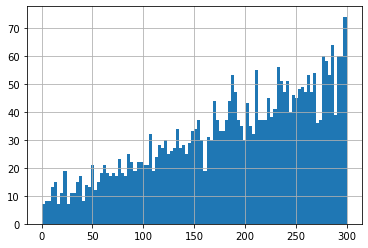

In [75]:
sdf[sdf.host_NSAID != -1].host_distance.hist(bins=100)